In [28]:
# check OpenAI API key in environment, interaactively set it if not not present 

import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [29]:
FILE_PATH = "media/sample_leads_10.csv"
EMAIL_TEMPLATE = "media/email_template.md"

In [30]:
# Load CSV File and extract data using lead_generator

import csv
from dataclasses import dataclass

@dataclass
class Lead:
    # Lead dataclass to store data
    name: str
    email: str
    company: str
    job_title: str
    industry: str

    def str(self):
        return f"""name={self.name}, email={self.email}, 
                company={self.company}, job_title={self.job_title}, 
                industry={self.industry}"""


def lead_generator():
    with open(FILE_PATH, newline="") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            yield Lead(
                name=row["Name"],
                email=row["Email"],
                company=row["Company"],
                job_title=row["Job Title"],
                industry=row["Industry"],
            ).str()

leads = lead_generator()

In [31]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

In [32]:
# System prompts for Email Construction, Quality Check and Orchestrator Agents
eca_sys_msg = SystemMessage(content="Write an email based on the given template by filling in the"
                                    " template with personalized content for the lead.")

qca_sys_msg = SystemMessage(content="You are a helpful assistant tasked with comparing two emails"
                                    " based on relevance, tone, engagement potential and selecting the best one."
                                    " return LLM_1 for first email or LLM_2 for second.")

o10r_sys_msg = SystemMessage(content="You are a helpful assistant tasked with writing emails for business leads."
                                    " Use Email Construction Agents and write two different emails for the same lead."
                                    " Once you have the two emails use Quality Check Agent to select best one." 
                                    " Which will tell LLM_1 or LLM_2"
                                    " Save all the output in a file. ")

In [33]:
# tools functions -  here Email Construction and Quality Check Agents are also used as tools by Orchestrator

def get_email_template() -> str:
    """Get email template"""
    with open(EMAIL_TEMPLATE, "r") as f:
        return f.read().replace('\\n','\n')
h
def get_lead() -> int:
    """Get next lead from lead iterator"""
    return next(leads)

def email_agent_1(lead_details: str) -> str:
    """Email Construction Agent 1 used to write email based on lead data
    
    Args:
        lead_details: str
    """
    llm_EA1 = ChatOpenAI(model="gpt-4")
    return llm_EA1.invoke([eca_sys_msg] + [SystemMessage(content=lead_details)])


def email_agent_2(lead_details: str) -> str:
    """Email Construction Agent 2 used to write email based on lead data
    
    Args:
        lead_details: str
    """
    llm_EA2 = ChatOpenAI(model="gpt-3.5-turbo")    
    return llm_EA2.invoke([eca_sys_msg] + [SystemMessage(content=lead_details)])

def quality_check_agent(email_1: str, email_2: str) -> str:
    """Quality check email used to compare and select the best email out of two.
    
    Args:
        email_1: str
        email_2: str
    """
    llm_QCA = ChatOpenAI(model="gpt-4o")
    return llm_QCA.invoke([qca_sys_msg] + [SystemMessage(content=email_1 + email_2)])


def save_to_file(name: str, 
                 email: str, 
                 company: str, 
                 job_title: str, 
                 email_llm_1: str, 
                 email_llm_2: str, 
                 selected_email: str) -> None:
    """Store both generated emails along with the comparison result in a file."""
    import json
    with open(f'generated/{name}.json', 'w') as f:
        json.dump({
        "name": name,
        "email": email,
        "company": company,
        "job_title": job_title,
        "email_llm_1": email_llm_1,
        "email_llm_2": email_llm_2,
        "selected_email": selected_email
    }, f)


tools = [get_lead, get_email_template, email_agent_1, email_agent_2, quality_check_agent, save_to_file]

In [34]:
from langchain_openai import ChatOpenAI

# orchestrator node
llm_orchestrator = ChatOpenAI(model="gpt-3.5-turbo")
llm_with_tools = llm_orchestrator.bind_tools(tools)

# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([o10r_sys_msg] + state["messages"])]}


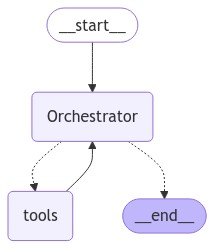

In [35]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# nodes: Orchestrator and tools
builder.add_node("Orchestrator", assistant)

builder.add_node("tools", ToolNode(tools))

# edges
builder.add_edge(START, "Orchestrator")
builder.add_conditional_edges("Orchestrator", tools_condition)
builder.add_edge("tools", "Orchestrator")

graph = builder.compile()

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [42]:
messages = [HumanMessage(content="Get two leads simultaneously and email template and use email_agent_1 and email_agent_2"
                                 " to write 2 emails for each lead and quality_check_agent to pick the best out of two for each elad." 
                                 " Save the output to a file.")]

messages = graph.invoke({"messages": messages})

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

In [ ]:
for m in messages['messages']:
    m.pretty_print()